In [1]:
using SpecialFunctions
using QuantumOptics

function fidelity(ρ, σ)
    tr(sqrt(sqrt(ρ) * σ * sqrt(ρ)))^(1/2)
end

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function sample_across_unit_disk(f, discretization)
    x = y = Array(range(-1, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end

function unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    """Each Zernike array is of arbitrary length, but they are ordered by order. The first is Z00 to Zn0 where
    n is the number of 0th order zernike polynomials being considered."""
    Pevens = []
    eventuples = []
    for (n, zeven) in enumerate(zernike_coefficients_even)
        neven = n - 1
        push!(Pevens, [zeven[i] * R(neven, i-1, ρ) for i in Array(range(1, length(zeven), step=1))])
    end
    for i in range(1, length(Pevens), step=1)
        rotationeven = - (i - 1) * ω * t
        total = 0
        for peven in Pevens
            if length(peven) >= i
                total += peven[i]
            end
        end    
        push!(eventuples, (i - 1, total, rotationeven))
    end

    Podds = []
    oddtuples = []
    for (n, zodd) in enumerate(zernike_coefficients_odd)
        nodd = n - 1
        push!(Podds, [zodd[i] * R(nodd, i-1, ρ) for i in Array(range(1, length(zodd), step=1))])
    end
    for i in range(1, length(Podds), step=1)
        rotationodd = - (i - 1) * ω * t
        total = 0
        for podd in Podds
            if length(podd) >= i
                total += podd[i]
            end
        end    
        push!(oddtuples, (i - 1, total, rotationodd))
    end
    eventuples, oddtuples
end

function infidelity_across_disk(F1, F2)
    function infidelity_polar(ρ, ϕ)
        ψ1 = F1(ρ, ϕ).data
        ψ2 = F2(ρ, ϕ).data
        1 - real(fidelity(ψ1, ψ2))
    end
end

function H_odf(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, μ, ω)
    eventuples, oddtuples = unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    eventerm = oddterm = 0
    if length(eventuples) > 0
        eventerm = mapreduce(x->x[2]*cos(x[1]*ϕ + x[3]), +, eventuples)
    end
    if length(oddtuples) > 0
        oddterm = mapreduce(x->x[2]*sin(x[1]*ϕ + x[3]), +, oddtuples)
    end
    U * cos(-μ*t + ψ + eventerm + oddterm) 
end

toarray(s::Union{Set, Array}) = [toarray.(s)...]
toarray(v::Number) = v

toarray (generic function with 2 methods)

In [79]:
max_order = 5
discretization = 100
zernike_samples = []
ordering = []
for n in range(0, max_order, step=1)
    for m in range(0, n, step=1)
        if (n-m)%2 == 0
            Zeven(ρ, ϕ) = R(n, m, ρ) * cos(m * ϕ)
            push!(zernike_samples, sample_across_unit_disk(Zeven, discretization)[3][:])
            push!(ordering, (n, m))
            if m !=0
                Zodd(ρ, ϕ) = R(n, m, ρ) * sin(m * ϕ)
                push!(zernike_samples, sample_across_unit_disk(Zodd, discretization)[3][:])
                push!(ordering, (n, -m))
            end
        end
    end
end

In [80]:
Z = reduce(hcat, zernike_samples);

In [92]:
σ = .5
amp = .001 # Used to make the small angle approximation work better.
function gaussian(σ)
    function func(ρ, ϕ)
        amp * exp(-ρ^2/σ^2)
    end
end
xx, yy, zz = sample_across_unit_disk(gaussian(σ), discretization)
G = zz[:];

In [93]:
function least_squares_solution(mat, y)
    inv(transpose(mat) * mat)*transpose(mat) * y
end

least_squares_solution (generic function with 1 method)

In [94]:
coefficients = least_squares_solution(Z, G)

21-element Array{BigFloat,1}:
  0.0002456903532851400286321892303884053092328287850858308744569699464952728121084309
 -6.655264548900126462330395351364067122622411816446782735317784451958550348076975e-24
 -3.710102132609081842748649779029719824124489583174854402694603369309909666853737e-82
 -0.0003948026933293484243224646116416264233655335462975513847888804652219872430508218
  2.204462609003982012431871599784559711785791465302073014964918923799957038408457e-22
  3.860668192101021688604214130103766726456284685925967120389805795327689559681308e-84
 -2.736640068380987765446550036395011462197480521663687835118167787604234901584946e-22
  1.850984495808861178528995117297817277777044171718251849313824422550543000424004e-80
 -1.427734501427440509489069269609901376561532445694304540791097531654388634029681e-22
  8.915569744958626086216665164452965293629713434698366736686858183343411089824035e-82
  0.0002394119292299286245752044774784968085318111369404119318033072524931360188856868
 -1.066192829

In [95]:
reconstruction = zeros(discretization*discretization)
for (i, zernike_sample) in enumerate(zernike_samples)
    reconstruction += coefficients[i] * zernike_sample
end

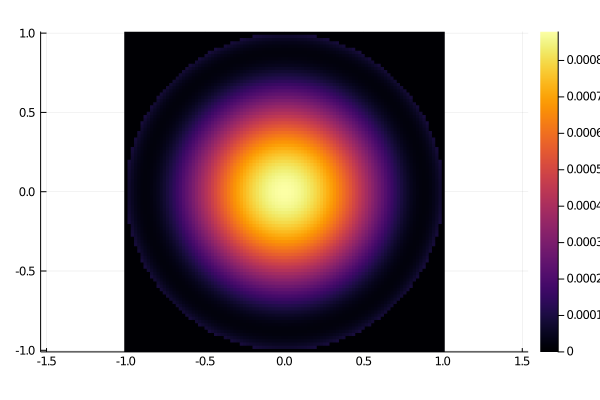

In [96]:
using Plots
plot(heatmap(xx, yy, reshape(reconstruction, (discretization, discretization))), aspectratio = true)

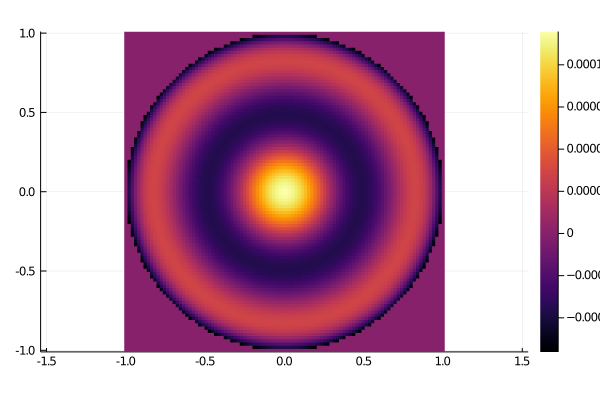

In [97]:
using Plots
diff = sample_across_unit_disk(gaussian(σ), discretization)[3] - reshape(reconstruction, (discretization, discretization))
plot(heatmap(xx, yy, diff), aspectratio = true)

In [98]:
center = reshape(reconstruction, (discretization, discretization))[Int(discretization/2), Int(discretization/2)]

0.0008794507805812174470661852824991739775356026216508743701255145103847819367070792

In [99]:
lookup = Dict(zip(ordering, coefficients));

In [100]:
zernike_even_coefficients = []
zernike_odd_coefficients = []
curr_even = []
curr_odd = []
for n in range(0, max_order, step=1)
    for m in range(0, n, step=1)
        if (n-m)%2 != 0
            push!(curr_even, 0)
            push!(curr_odd, 0)
        else
            if m == 0
                push!(curr_even, lookup[(n, m)]/2)
                push!(curr_odd, lookup[(n, -m)]/2)
            else
                push!(curr_even, lookup[(n, m)])
                push!(curr_odd, lookup[(n, -m)])
            end
        end
    end
    push!(zernike_even_coefficients, curr_even)
    push!(zernike_odd_coefficients, curr_odd)
    curr_even = []
    curr_odd = []
end

In [101]:
function sequential_exact_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, θ, ω, b)
    """Apply all the zernike coefficients given, in order, for time T each."""
    orders = range(0, max(length(zernikeeven), length(zernikeodd)) - 1, step=1)
    function evaluator(ρ, ϕ)
        ψ = ψ0
        for order in orders
            μ = order * ω
            H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
            _, ψ = timeevolution.master_dynamic(T, ψ, H; rates=[Γ])
            ψ = last(ψ)
        end
        ψ
    end
end

function gaussian_spin_profile(ρ, ϕ)
    ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
    H(t, _) = exp(-ρ^2/σ^2) * sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
    evolution_time = π/2
    step_size = evolution_time/1
    T = [0.0:step_size:evolution_time;];
    _, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
    last(ψ)
end

gaussian_spin_profile (generic function with 1 method)

In [102]:
Γ = 1/62
ω = 2*π*180E3
θ = -π/2;

In [103]:
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
evolution_time =  50E-6
U = π/(amp * evolution_time)
step_size = evolution_time/1
T = [0.0:step_size:evolution_time;];
sequential_exact_evolution = sequential_exact_evolution_evaluator_factory(ψ0, T, zernike_even_coefficients, zernike_odd_coefficients, U, θ, ω, b)

(::var"#evaluator#92"{Ket{SpinBasis{1//2,Int64},Array{Complex{Float64},1}},Array{Float64,1},Array{Any,1},Array{Any,1},Float64,Float64,Float64,SpinBasis{1//2,Int64},StepRange{Int64,Int64}}) (generic function with 1 method)

In [74]:
plotting_discretization = 10
plot(heatmap(sample_across_unit_disk(infidelity_across_disk(gaussian_spin_profile, sequential_exact_evolution), plotting_discretization)), aspectratio = true)

LoadError: InterruptException:

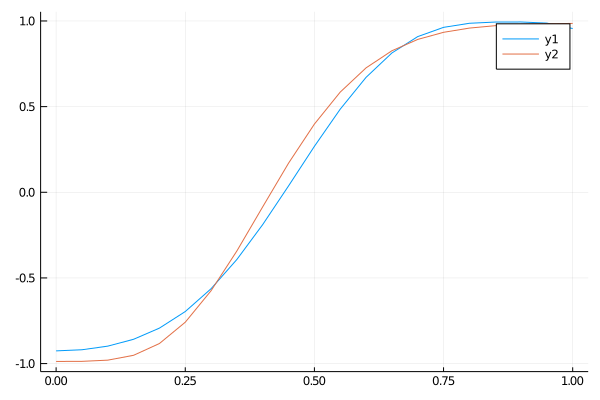

In [104]:
using Plots
max_ρ = 1
min_ρ = .0
ρs = range(min_ρ, max_ρ, step=max_ρ/20)
target = [Real.(expect(sigmax(b), gaussian_spin_profile(ρ, 0.))) for ρ in ρs]
ys = [Real.(expect(sigmax(b), sequential_exact_evolution(ρ, 0.))) for ρ in ρs];
plot(ρs, [ys, target])